In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pandas import Timestamp
import gpflow
from gpflow.utilities import print_summary
from gpflow import set_trainable
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta
from gpflow.config import default_float
import datetime as dt
#import ee
import requests

In [3]:
def preprocessing(df, lat, long):
    df.set_index('time', inplace=True)
    df.dropna(inplace=True)
    hourly_df = df.resample('H').mean()
    hourly_df['latitude'], hourly_df['longtitude']=lat,long
    hourly_df.reset_index(inplace=True)
    hourly_df.dropna(inplace=True)
    hourly_df['time'] = [time.timestamp()/3600 for time in hourly_df['time']]
    return hourly_df

In [4]:
f = lambda time: Timestamp.fromtimestamp(time*3600)
f2 = np.vectorize(f)

In [5]:
filename = 'D:\PYTHON\WORK-2022\spatial-model/fort_portal/FORT_FINAL_data.csv'
data = pd.read_csv(filename, parse_dates=['time'], usecols =['time', 'latitude', 'longtitude', 'pm2_5'])
data.head()

,pm2_5,time,latitude,longtitude
0,20.0791,2022-07-14 22:00:00+00:00,0.6888,30.26955
1,18.4292,2022-07-14 21:00:00+00:00,0.6888,30.26955
2,20.0652,2022-07-14 20:00:00+00:00,0.6888,30.26955
3,48.3041,2022-07-14 19:00:00+00:00,0.6888,30.26955
4,139.4756,2022-07-14 18:00:00+00:00,0.6888,30.26955


In [6]:
data.shape

(3438, 4)

In [7]:
latitudes = data['latitude'].unique()
len(latitudes)

9

In [8]:
longtitudes = data['longtitude'].unique()
len(longtitudes)

9

In [9]:
latitudes[8]

0.68736

In [10]:
longtitudes[8]

30.24734

In [11]:
final_df = pd.DataFrame()
for i, latitude in enumerate(latitudes):
    df = data[data['latitude'] == latitude]
    longtitude = longtitudes[i]
    processed_df = preprocessing(df, latitude, longtitude)
    final_df = pd.concat([final_df, processed_df])
final_df.reset_index(drop=True, inplace=True)
final_df.head()

,time,pm2_5,latitude,longtitude
0,459792.0,20.1120,0.6888,30.26955
1,459793.0,29.2227,0.6888,30.26955
2,459794.0,10.4025,0.6888,30.26955
3,459795.0,11.6838,0.6888,30.26955
4,459796.0,22.7920,0.6888,30.26955


In [12]:
final_df.latitude.unique()

array([0.6888  , 0.64726 , 0.6569  , 0.65561 , 0.657624, 0.6301  ,
       0.66668 , 0.6237  , 0.68736 ])

In [13]:
ids = ["aq_g5_36", "aq_g533", "aq_g530", "aq_g528", "aq_10", "aq_g534","aq_g527","aq_g526" ,"aq_g535"]
locations = ['Kiteere,Kibimba Ward', 'Toro Palace, Bazaar Ward', 'Mpanga Market, Njara Ward', 'Lory Park, Rwengoma',
             'Rwengoma', 'Kinyamaska,Kijanja Ward', 'Booma East, Njara Ward' ,'Kasusu Ward,Central Division','MMUniversity,Saaka'
            ]
len(ids)

9

In [14]:
final_df.shape

(3438, 4)

In [15]:
data.latitude.unique()

array([0.6888  , 0.64726 , 0.6569  , 0.65561 , 0.657624, 0.6301  ,
       0.66668 , 0.6237  , 0.68736 ])

In [16]:
final_df.latitude.unique()

array([0.6888  , 0.64726 , 0.6569  , 0.65561 , 0.657624, 0.6301  ,
       0.66668 , 0.6237  , 0.68736 ])

In [17]:
X = final_df[['longtitude', 'latitude', 'time']]
#X = final_df[['time','longtitude', 'latitude', 'day_of_week', 'hour']]
Y = final_df[['pm2_5']]
X.head()

,longtitude,latitude,time
0,30.26955,0.6888,459792.0
1,30.26955,0.6888,459793.0
2,30.26955,0.6888,459794.0
3,30.26955,0.6888,459795.0
4,30.26955,0.6888,459796.0


In [18]:
X.describe()

,longtitude,latitude,time
count,3438.000000,3438.000000,3438.000000
mean,30.269801,0.662444,460140.335660
std,0.011411,0.022788,207.319131
min,30.247340,0.623700,459792.000000
25%,30.267630,0.630100,459958.000000
50%,30.269550,0.666680,460134.000000
75%,30.273400,0.687360,460318.000000
max,30.285560,0.688800,460510.000000


In [19]:
X = np.asarray(X)
X

array([[3.026955e+01, 6.888000e-01, 4.597920e+05],
       [3.026955e+01, 6.888000e-01, 4.597930e+05],
       [3.026955e+01, 6.888000e-01, 4.597940e+05],
       ...,
       [3.024734e+01, 6.873600e-01, 4.605050e+05],
       [3.024734e+01, 6.873600e-01, 4.605060e+05],
       [3.024734e+01, 6.873600e-01, 4.605100e+05]])

In [20]:
Y = np.asarray(Y)
Y

array([[20.112 ],
       [29.2227],
       [10.4025],
       ...,
       [47.6305],
       [44.9457],
       [20.9467]])

In [21]:
X.shape, Y.shape

((3438, 3), (3438, 1))

In [22]:
np.count_nonzero(np.isnan(X))

0

In [23]:
longs = [X[:,0][index] for index in sorted(np.unique(X[:,0], return_index=True)[1])]
lats = [X[:,1][index] for index in sorted(np.unique(X[:,1], return_index=True)[1])]
len(longs), len(lats)

(9, 9)

In [24]:
max(lats) - min(lats)

0.06509999999999994

In [25]:
def cross_validation(X, Y, long, lat):
    
    location_indices = np.where(np.logical_and(X[:,0]==long, X[:,1]==lat))
    
    Xtraining = X[np.logical_not(np.logical_and(X[:,0]==long, X[:,1]==lat))]
    Ytraining = np.delete(Y, slice(location_indices[0][0],location_indices[0][-1]+1), axis=0)
    
    Xtest = X[np.logical_and(X[:,0]==long, X[:,1]==lat)]
    Ytest = Y[location_indices[0][0]:location_indices[0][-1]+1]
    
    k = gpflow.kernels.RBF() + gpflow.kernels.Bias()
    m = gpflow.models.GPR(data=(Xtraining, Ytraining), kernel=k, mean_function=None)
    m.likelihood.variance.assign(200)
    set_trainable(m.likelihood.variance, False)
    
    opt = gpflow.optimizers.Scipy()
        
    def objective_closure():
        return - m.log_marginal_likelihood()
    
    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))
    mean, var = m.predict_f(Xtest)
        
    rmse = sqrt(mean_squared_error(Ytest, mean.numpy()))
    
    return mean.numpy(), var.numpy(), Xtest, Ytest, round(rmse, 2)

aq_g5_36 successful


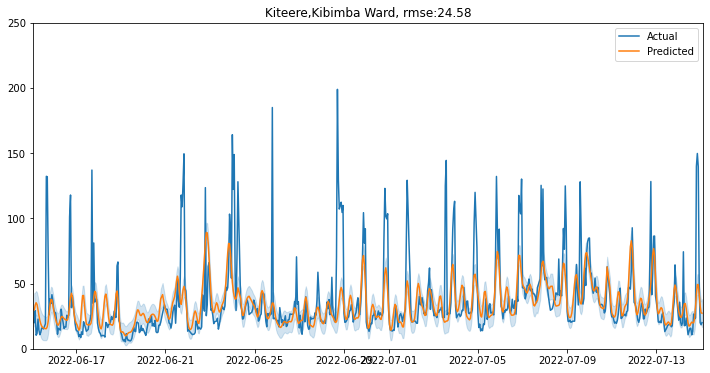

aq_g533 successful


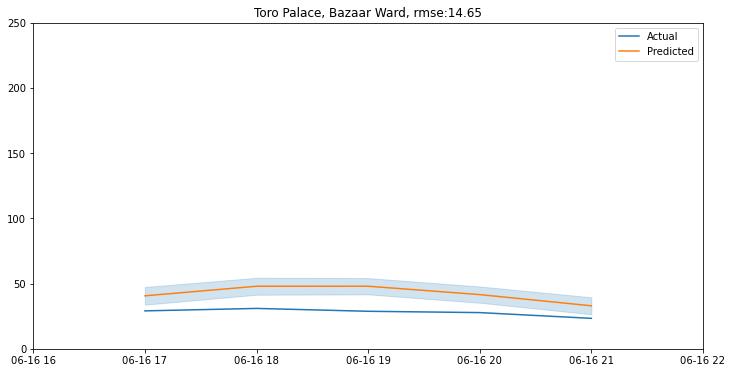

aq_g530 successful


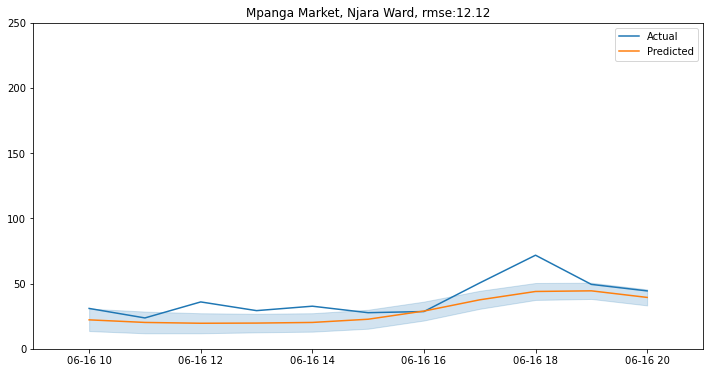

aq_g528 successful


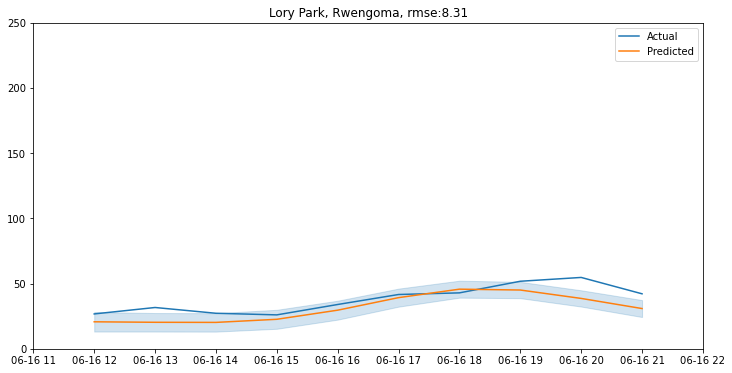

aq_10 successful


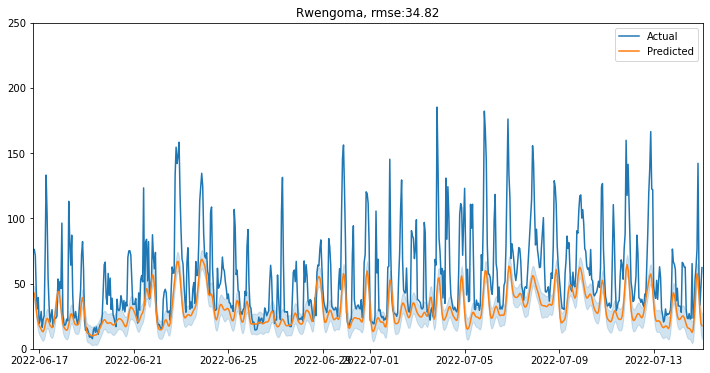

aq_g534 successful


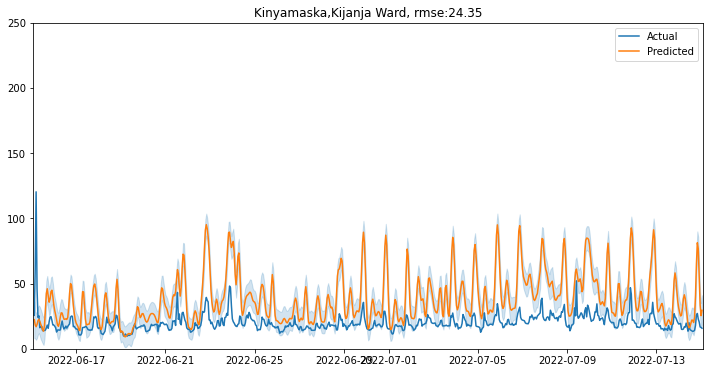

aq_g527 successful


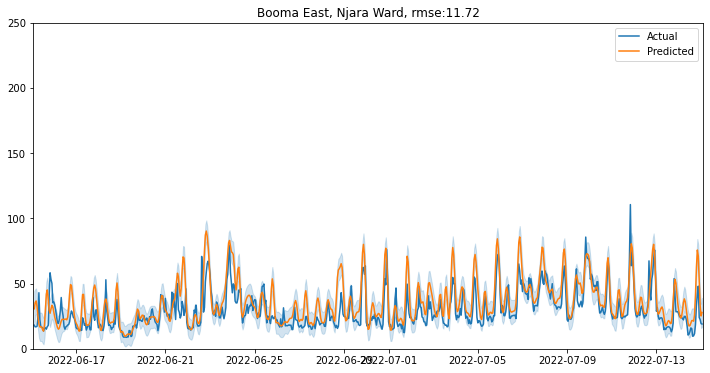

aq_g526 successful


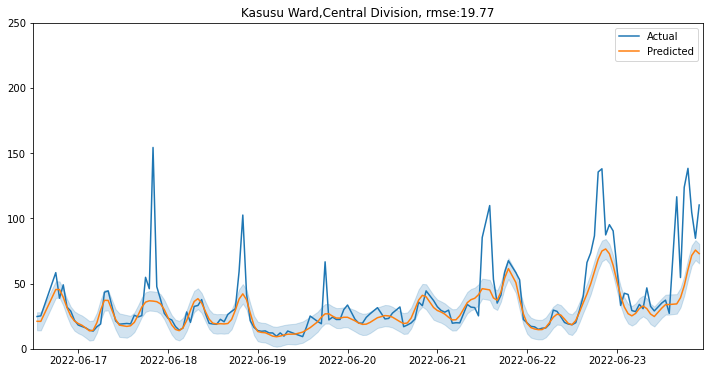

aq_g535 successful


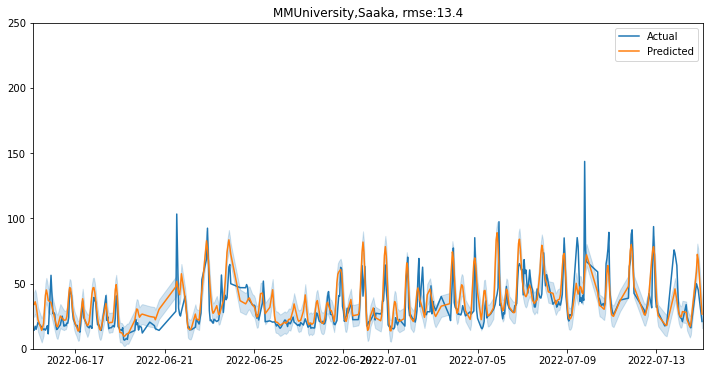

In [26]:
rmse_list =[]
for i in range(len(longs)):
    try:
        mean, var, Xtest, Ytest, rmse = cross_validation(X, Y, longs[i], lats[i])
        print(f'{ids[i]} successful')
        rmse_list.append(rmse)

        plt.figure(figsize=(12,6))
        plt.title(f'{locations[i]}, rmse:{rmse}')
        plt.xlim(f2(Xtest[:,2]).min()-timedelta(hours=1), f2(Xtest[:,2]).max()+timedelta(hours=1))
        plt.ylim(0,250)
        plt.plot(f2(Xtest[:, 2]), Ytest, label='Actual')
        plt.plot(f2(Xtest[:, 2]), mean, label='Predicted')
        plt.fill_between(f2(Xtest[:, 2]),
                        mean[:,0]-1.96*np.sqrt(var[:, 0]),
                         mean[:,0]+1.96*np.sqrt(var[:, 0]),
                        color="C0",
                         alpha=0.2)
        plt.legend(loc='best')
     #   plt.savefig(f'D:\PYTHON\WORK-2022\spatial-model/fort_portal/img/data_visuals/plots/{ids[i]}.png') 
        plt.show()
        plt.close()
    except Exception as e:
        print(f'{ids[i]} failed')
        print(e)
        rmse_list.append(None)

In [27]:
np.min(rmse_list),np.max(rmse_list), np.mean(rmse_list), np.median(rmse_list)

(8.31, 34.82, 18.191111111111113, 14.65)

In [28]:
rmse_list

[24.58, 14.65, 12.12, 8.31, 34.82, 24.35, 11.72, 19.77, 13.4]

In [29]:
locations_df = pd.read_csv('D:\PYTHON\WORK-2022\spatial-model/fort_portal/Fort_portal_devices.csv')
locations_df.head()

,Unnamed: 0,name,id,lat,long
0,0,aq_g5_36,1429567,0.688800,30.26955
1,1,aq_g533,1379966,0.647260,30.26844
2,2,aq_g530,1375499,0.656900,30.27896
3,3,aq_g528,1375496,0.655610,30.27199
4,4,aq_10,676000,0.657624,30.26763


In [30]:
considered_df = pd.DataFrame()
count =0
for i in range(len(longs)):
    row = locations_df.loc[locations_df['long'] == longs[i]]
    considered_df = pd.concat([considered_df, row])
considered_df.reset_index(drop=True, inplace=True)
considered_df.shape[0]

9

In [31]:
considered_df

,Unnamed: 0,name,id,lat,long
0,0,aq_g5_36,1429567,0.688800,30.26955
1,1,aq_g533,1379966,0.647260,30.26844
2,2,aq_g530,1375499,0.656900,30.27896
3,3,aq_g528,1375496,0.655610,30.27199
4,4,aq_10,676000,0.657624,30.26763
5,5,aq_g534,1379967,0.630100,30.27340
6,6,aq_g527,1375495,0.666680,30.28556
7,7,aq_g526,1375494,0.623700,30.25565
8,8,aq_g535,1379969,0.687360,30.24734


In [32]:
new_list = rmse_list.copy()
K = np.array(new_list)
K.argsort()[-3:]

array([5, 0, 4], dtype=int64)

In [33]:
rmse_list[4], rmse_list[3], rmse_list[0]

(34.82, 8.31, 24.58)

In [34]:
considered_df.head()

,Unnamed: 0,name,id,lat,long
0,0,aq_g5_36,1429567,0.688800,30.26955
1,1,aq_g533,1379966,0.647260,30.26844
2,2,aq_g530,1375499,0.656900,30.27896
3,3,aq_g528,1375496,0.655610,30.27199
4,4,aq_10,676000,0.657624,30.26763


In [35]:
import folium
from branca.element import Figure

fig=Figure(width=800,height=400)
kawempe_map=folium.Map(width=800,height=400,location=[0.6558598,30.276395],zoom_start=13,min_zoom=8,max_zoom=14)
fig.add_child(kawempe_map)

for index, row in considered_df.iterrows():
    label = f'{row["name"]} - {rmse_list[index]}'
    if rmse_list[index]>=0 and rmse_list[index]<10:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='blue'),
                      tooltip=label).add_to(kawempe_map)
    elif rmse_list[index]>=10 and rmse_list[index]<20:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='green'), 
                      tooltip=label).add_to(kawempe_map)
    elif rmse_list[index]>=20 and rmse_list[index]<30:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='orange'), 
                      tooltip=label).add_to(kawempe_map)
    if rmse_list[index]>=30 and rmse_list[index]<40:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='red'),
                      tooltip=label).add_to(kawempe_map)
    elif rmse_list[index]>=40 and rmse_list[index]<50:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='purple'),
                      tooltip=label).add_to(kawempe_map)
    elif rmse_list[index]>=50 and rmse_list[index]<60:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='darkpurple'), 
                      tooltip=label).add_to(kawempe_map)
    else:
        folium.Marker(location=[row['lat'], row['long']], 
                      popup=folium.Popup(html=label, show=True, sticky=True), 
                      icon=folium.Icon(color='gray'),
                      tooltip=label).add_to(kawempe_map)
kawempe_map